In [53]:
import cv2
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/tips&tricks/Project/lib')
from engine import train_one_epoch, evaluate
import utils

In [59]:
def img_show(img):
    plt.figure(dpi=200)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [5]:
CLASS_LABEL_MAP = {
    "stop": 1,        # red
    "warning": 2,     # yellow
    "go": 3,          # green
    "goForward": 4,   # unknown
    "goLeft": 4,      # unknown
    "warningLeft": 4,  # unknown
    "stopLeft": 4,    # unknown
}

LABEL_CLASS_MAP = {
    1: "red",
    2: "yellow",
    3: "green",
    4: "unknown",
}


def createDataFrame(files):
    df_all = []

    for f in files:
        df = pd.read_csv(str(f), ";")

        # change 'Filename' value to absolute path
        def abs_path(filename, f_path):
            f_path_split = f_path.parts
            Annotations_idx = f_path_split.index('Annotations')
            root_dir = Path(*f_path_split[:Annotations_idx])
            type_dir = f_path_split[Annotations_idx + 2]  # dayTrain, daySequence1, ...
            clip_dir = f_path_split[Annotations_idx + 3:-1]  # dayClip1
            img_name = filename.split("/")[-1]

            return str(root_dir.joinpath(*[type_dir]*2,
                                         *clip_dir,
                                         "frames",
                                         img_name))

        df["Filename"] = df["Filename"].apply(abs_path, args=(f,))
        df_all.append(df)

    df_all_concat = pd.concat(df_all, ignore_index=True)
    df_all_concat.drop_duplicates(inplace=True, ignore_index=True)

    return df_all_concat


class LISADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # load all annotation files
        root_dir = Path(root_dir)
        search_dir = root_dir.joinpath("Annotations", "Annotations")
        annotationFiles = search_dir.glob("day*/**/*BOX.csv")
        self.annotations = createDataFrame(annotationFiles)

        # images
        self.imgs = self.annotations["Filename"].unique()

        # groupby_frame
        self.annotations_groupby_frame = self.annotations.groupby("Filename")
        
    def getAnnotation(self, img_path):
        annotation = self.annotations_groupby_frame.get_group(img_path)
        return annotation[
            [
                "Filename",
                "Annotation tag",
                "Upper left corner X",
                "Upper left corner Y",
                "Lower right corner X",
                "Lower right corner Y",
            ]
        ]

    def __getitem__(self, idx):
        # load image at that index
        img_path = self.imgs[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError('Incorrect path')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        annotation = self.getAnnotation(img_path)

        # get bounding box coordinates for each traffic light
        boxes = []
        state = []
        affect = []
        for _, row in annotation.iterrows():
            xmin = row["Upper left corner X"]
            xmax = row["Lower right corner X"]
            ymin = row["Upper left corner Y"]
            ymax = row["Lower right corner Y"]
            boxes.append([xmin, ymin, xmax, ymax])
            state.append(CLASS_LABEL_MAP[row["Annotation tag"]])
            if CLASS_LABEL_MAP[row["Annotation tag"]] > 3:
                affect.append(False)
            else:
                affect.append(True)

        # boxes = torch.as_tensor(boxes, dtype=torch.float32)
        sample = {
            "image": image,
            "boxes": np.array(boxes),
            "labels": np.ones(len(boxes))
            # "state": state,
            # "affect": np.array(affect)
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.imgs)

In [6]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, boxes, labels = sample['image'], sample['boxes'], sample['labels']
        image = torch.from_numpy(image.transpose((2, 0, 1)))
        image = image.float().div(255)
        boxes = torch.from_numpy(boxes).float()
        labels = torch.tensor(labels, dtype=torch.int64)
        return {'image': image,
                'boxes': boxes,
                'labels': labels}

In [7]:
def collate_fn(batch):
    images = []
    targets = []
    for sample in batch:
        d = {}
        d['boxes'] = sample['boxes']
        d['labels'] = sample['labels']
        targets.append(d)
        images.append(sample['image'])
    return images, targets

In [8]:
def get_loaders(batch_size=128, num_workers=2, transform_train=ToTensor(), transform_test=ToTensor()):
    torch.manual_seed(123)  # To ensure the same sampling during each experiment
    
    train = LISADataset(root_dir='/content/drive/MyDrive/Datasets/lisa', transform=transform_train)
    test = LISADataset(root_dir='/content/drive/MyDrive/Datasets/lisa', transform=transform_test)
    
    # split the dataset in train and test set
    indices = torch.randperm(len(train)).tolist()
    train = torch.utils.data.Subset(train, indices[:-50])
    test = torch.utils.data.Subset(test, indices[-50:])

    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_fn, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    
    return train_loader, test_loader

In [9]:
#Check that we have a GPU
torch.cuda.is_available()

True

In [10]:
device = torch.device('cuda:0')

num_epochs = 10
lr = 0.005

transform_train = transforms.Compose([
    ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_loader, test_loader = get_loaders(batch_size=2, 
                                        num_workers=2, 
                                        transform_train=transform_train, 
                                        transform_test=transform_test)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)

model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [11]:
train_one_epoch(model, optimizer, train_loader, device, 0, print_freq=50)

Epoch: [0]  [    0/10099]  eta: 4 days, 15:52:35  lr: 0.000010  loss: 1.0779 (1.0779)  loss_classifier: 0.8495 (0.8495)  loss_box_reg: 0.1044 (0.1044)  loss_objectness: 0.0413 (0.0413)  loss_rpn_box_reg: 0.0827 (0.0827)  time: 39.8807  data: 38.8841  max mem: 2138
Epoch: [0]  [   50/10099]  eta: 5:31:26  lr: 0.000260  loss: 0.3857 (0.5865)  loss_classifier: 0.1531 (0.3380)  loss_box_reg: 0.1558 (0.1412)  loss_objectness: 0.0473 (0.0686)  loss_rpn_box_reg: 0.0249 (0.0387)  time: 0.5286  data: 0.0065  max mem: 2405
Epoch: [0]  [  100/10099]  eta: 3:31:18  lr: 0.000509  loss: 0.3274 (0.4674)  loss_classifier: 0.0797 (0.2205)  loss_box_reg: 0.1614 (0.1601)  loss_objectness: 0.0239 (0.0526)  loss_rpn_box_reg: 0.0215 (0.0343)  time: 0.5466  data: 0.0072  max mem: 2405
Epoch: [0]  [  150/10099]  eta: 2:50:16  lr: 0.000759  loss: 0.2741 (0.4072)  loss_classifier: 0.0743 (0.1714)  loss_box_reg: 0.1528 (0.1576)  loss_objectness: 0.0273 (0.0451)  loss_rpn_box_reg: 0.0171 (0.0331)  time: 0.5363  d

In [13]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/tips&tricks/Project/models/state_dict_model.pt')

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/tips&tricks/Project/models/state_dict_model.pt'))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


<All keys matched successfully>

In [ ]:
device = torch.device('cuda:0')
model.to(device)

In [57]:
img_path = '/content/drive/MyDrive/Datasets/test/video_0/frames/out-062.jpg'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_tensor = torch.from_numpy(image.transpose((2, 0, 1)))
image_tensor = image_tensor.float().div(255)
model.eval()
with torch.no_grad():
    image_tensor = image_tensor.to(device)
    target = model([image_tensor])

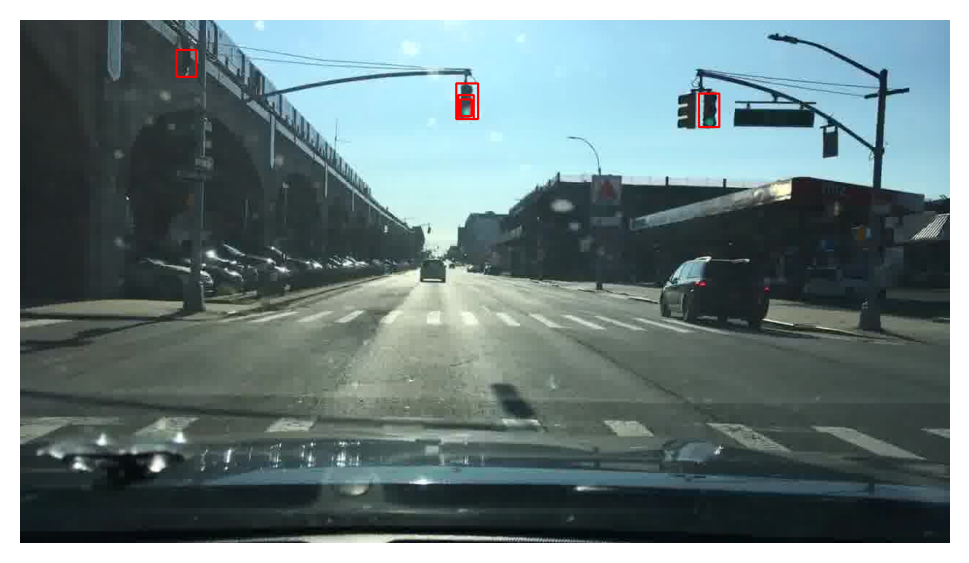

In [60]:
boxes = target[0]['boxes'].tolist()
for box in boxes:
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
img_show(image)

In [ ]:
# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     evaluate(model, test_loader, device=device)
# 
# print("That's it!")

In [ ]:
# root_dir = Path(root_dir)
# paths = root_dir.glob("*.jpg")
# self.imgs = [str(path) for path in paths]